# Model A Basic (Multi-class): Stage 1 vs 2 vs 3

Simple 3-class classification without feature engineering.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_validate,StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
# Load Data
df = pd.read_csv('./data/liver_cirrhosis.csv')

if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

df = df.dropna(subset=['Stage'])
df_basic = df[df['Stage'].isin([1, 2, 3])].copy()

print(f"Shape: {df_basic.shape}")
print("\nStage Distribution:")
print(df_basic['Stage'].value_counts().sort_index())

Shape: (25000, 19)

Stage Distribution:
Stage
1    8265
2    8441
3    8294
Name: count, dtype: int64


## 1. Target Definition (Multi-class)
**Stage 1 vs Stage 2 vs Stage 3**

In [4]:
# Multi-class target: 0, 1, 2 (for Stages 1, 2, 3)
df_basic['Target'] = df_basic['Stage'] - 1

print("Target Distribution:")
print(df_basic['Target'].value_counts().sort_index())

Target Distribution:
Target
0    8265
1    8441
2    8294
Name: count, dtype: int64


## 2. Features (No Engineering)

In [5]:
# Same features as binary model
feature_cols = [ 'Ascites', 'Hepatomegaly', 
                'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin',
                'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

X = df_basic[feature_cols].copy()
y = df_basic['Target']

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Features: {len(feature_cols)}")
print(f"Categorical: {len(categorical_cols)}, Numerical: {len(numeric_cols)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")

preprocessor = ColumnTransformer([
    ('num', RobustScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

Features: 13
Categorical: 4, Numerical: 9

Train: (20000, 13), Test: (5000, 13)


## 3. Optuna Tuning (Multi-class)

In [ ]:
print("Starting Optuna Tuning (Multi-class)...")

# RF
def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'class_weight': 'balanced'
    }
    model = RandomForestClassifier(**param, random_state=42, n_jobs=-1)
    pipeline = ImbPipeline([('preprocessor', preprocessor),  ('classifier', model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_validate(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')['test_score'].mean()

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=10)
best_rf_params = study_rf.best_params
best_rf_params['class_weight'] = 'balanced'

# XGB (multi-class)
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'objective': 'multi:softprob',
        'num_class': 3
    }
    model = XGBClassifier(**param, random_state=42, verbosity=0)
    pipeline = ImbPipeline([('preprocessor', preprocessor),  ('classifier', model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_validate(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')['test_score'].mean()

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=10)
best_xgb_params = study_xgb.best_params
best_xgb_params.update({'use_label_encoder': False, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'num_class': 3})

# LGBM (multi-class)
def objective_lgbm(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'class_weight': 'balanced',
        'objective': 'multiclass',
        'num_class': 3,
        'verbose': -1
    }
    model = LGBMClassifier(**param, random_state=42)
    pipeline = ImbPipeline([('preprocessor', preprocessor),  ('classifier', model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_validate(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')['test_score'].mean()

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=10)
best_lgbm_params = study_lgbm.best_params
best_lgbm_params.update({'class_weight': 'balanced', 'objective': 'multiclass', 'num_class': 3, 'verbose': -1})

print("Best params obtained!")

Starting Optuna Tuning (Multi-class)...
Best params obtained!


## 4. Ensemble & Evaluation

Training ensemble...

Classification Report:
              precision    recall  f1-score   support

     Stage 1       0.97      0.95      0.96      1653
     Stage 2       0.94      0.97      0.95      1688
     Stage 3       0.98      0.97      0.97      1659

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000


Macro F1-Score: 0.9619


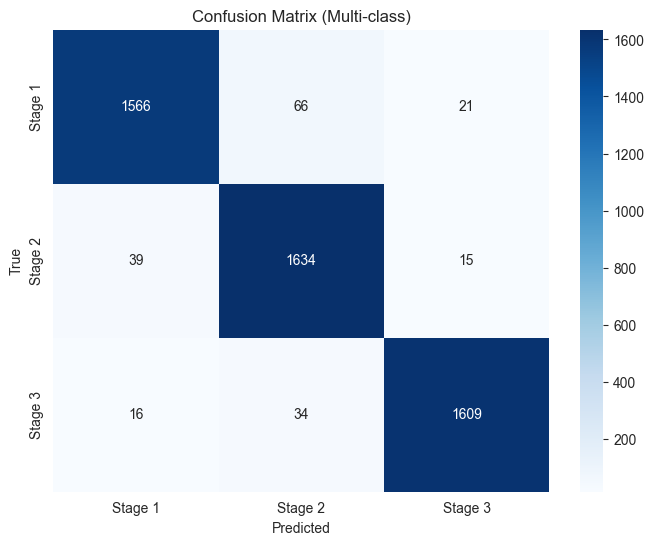

In [ ]:
# Ensemble
model_rf = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
model_xgb = XGBClassifier(**best_xgb_params, random_state=42)
model_lgbm = LGBMClassifier(**best_lgbm_params, random_state=42)

ensemble = VotingClassifier(
    estimators=[('rf', model_rf), ('xgb', model_xgb), ('lgbm', model_lgbm)],
    voting='soft'
)

final_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    
    ('ensemble', ensemble)
])

print("Training ensemble...")
final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Stage 1', 'Stage 2', 'Stage 3']))
print(f"\nMacro F1-Score: {f1_score(y_test, y_pred, average='macro'):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stage 1', 'Stage 2', 'Stage 3'], yticklabels=['Stage 1', 'Stage 2', 'Stage 3'])
plt.title('Confusion Matrix (Multi-class)')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


CALIBRATION OF MODELS (Fixed Pipeline)

Calibrating RandomForest...
  Log Loss (Uncalibrated): 0.1851
  Log Loss (Calibrated):   0.1611
  Improvement:             0.0240
  Brier Score (Calibrated) per class:
    Stage 1: 0.0306
    Stage 2: 0.0334
    Stage 3: 0.0191

Calibrating XGBoost...
  Log Loss (Uncalibrated): 0.1238
  Log Loss (Calibrated):   0.1194
  Improvement:             0.0045
  Brier Score (Calibrated) per class:
    Stage 1: 0.0222
    Stage 2: 0.0244
    Stage 3: 0.0143

Calibrating LightGBM...
  Log Loss (Uncalibrated): 0.1183
  Log Loss (Calibrated):   0.1188
  Improvement:             -0.0005
  Brier Score (Calibrated) per class:
    Stage 1: 0.0221
    Stage 2: 0.0239
    Stage 3: 0.0142


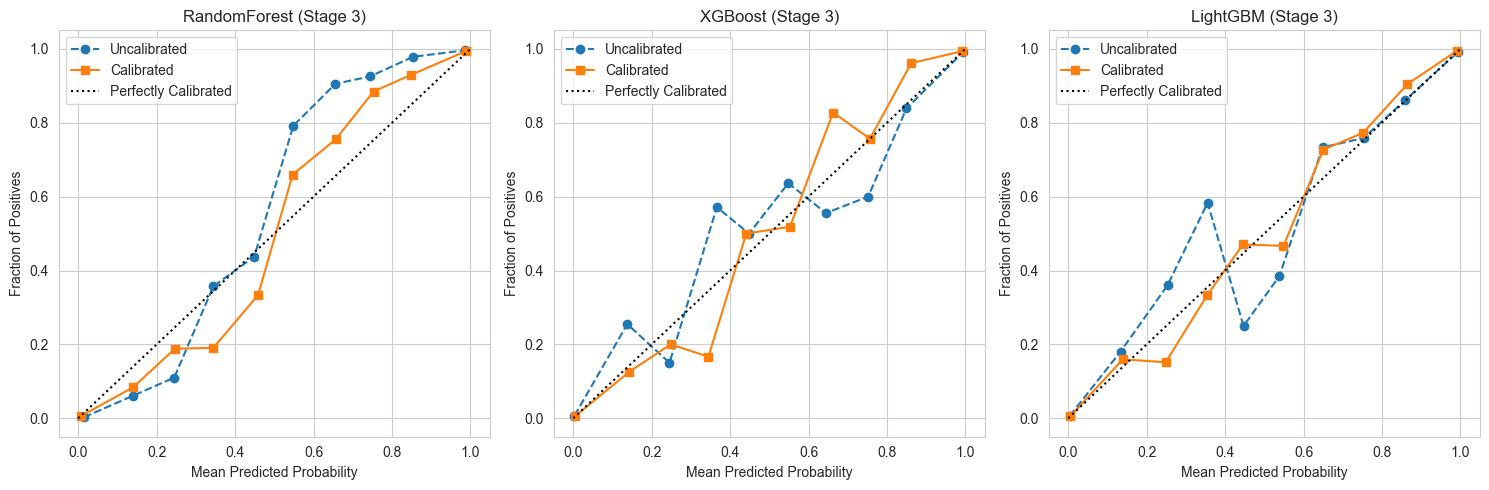


CALIBRATION COMPLETE


In [ ]:

# =====================================================================
# CALIBRATION OF MODELS (Multi-class) - FIXED
# =====================================================================
print('\n' + '='*70)
print('CALIBRATION OF MODELS (Fixed Pipeline)')
print('='*70)

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import log_loss, brier_score_loss
import matplotlib.pyplot as plt


pipelines = {
    'RandomForest': ImbPipeline([
        ('preprocessor', preprocessor),
        
        ('classifier', RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1))
    ]),
    'XGBoost': ImbPipeline([
        ('preprocessor', preprocessor),
        
        ('classifier', XGBClassifier(**best_xgb_params, random_state=42))
    ]),
    'LightGBM': ImbPipeline([
        ('preprocessor', preprocessor),
        
        ('classifier', LGBMClassifier(**best_lgbm_params, random_state=42))
    ])
}

# Store results
calibrated_models = {}
results_calib = {}

plt.figure(figsize=(15, 5))
plot_idx = 1

for name, pipeline in pipelines.items():
    print(f"\nCalibrating {name}...")
    
    # Wrap the PIPELINE in CalibratedClassifierCV
    # This ensures X_train splits are preprocessed independently.
    calibrated_clf = CalibratedClassifierCV(estimator=pipeline, method='isotonic', cv=3)
    
    # Fit the calibrated model on RAW X_train (which contains categorical strings like 'Y')
    try:
        calibrated_clf.fit(X_train, y_train)
        calibrated_models[name] = calibrated_clf
        
        # Evaluate
        # Note: pipeline.fit() updates the internal steps, but calibrated_clf makes its own copies.
        # So we fit an independent uncalibrated pipeline for comparison.
        pipeline_uncalib = pipeline # Reuse definition
        pipeline_uncalib.fit(X_train, y_train)
        
        y_prob_uncalib = pipeline_uncalib.predict_proba(X_test)
        y_prob_calib = calibrated_clf.predict_proba(X_test)
        
        loss_uncalib = log_loss(y_test, y_prob_uncalib)
        loss_calib = log_loss(y_test, y_prob_calib)
        
        print(f"  Log Loss (Uncalibrated): {loss_uncalib:.4f}")
        print(f"  Log Loss (Calibrated):   {loss_calib:.4f}")
        print(f"  Improvement:             {loss_uncalib - loss_calib:.4f}")
        
        # Metrics per class (Brier Score - One vs Rest)
        print("  Brier Score (Calibrated) per class:")
        for i, stage in enumerate(['Stage 1', 'Stage 2', 'Stage 3']):
            y_test_binary = (y_test == i).astype(int)
            prob_binary = y_prob_calib[:, i]
            bs = brier_score_loss(y_test_binary, prob_binary)
            print(f"    {stage}: {bs:.4f}")

        # Plot Comparison (Stage 3)
        ax = plt.subplot(1, 3, plot_idx)
        
        # Uncalibrated curve (Stage 3)
        y_test_3 = (y_test == 2).astype(int)
        prob_3_uncalib = y_prob_uncalib[:, 2]
        prob_true_u, prob_pred_u = calibration_curve(y_test_3, prob_3_uncalib, n_bins=10)
        
        # Calibrated curve (Stage 3)
        prob_3_calib = y_prob_calib[:, 2]
        prob_true_c, prob_pred_c = calibration_curve(y_test_3, prob_3_calib, n_bins=10)
        
        ax.plot(prob_pred_u, prob_true_u, marker='o', label='Uncalibrated', linestyle='--')
        ax.plot(prob_pred_c, prob_true_c, marker='s', label='Calibrated', linestyle='-')
        ax.plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
        
        ax.set_title(f'{name} (Stage 3)')
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives')
        ax.legend()
        
        plot_idx += 1

    except Exception as e:
        print(f"  Calibration failed for {name}: {e}")

plt.tight_layout()
plt.show()

print('\n' + '='*70)
print('CALIBRATION COMPLETE')
print('='*70)


In [22]:
from sklearn.metrics.pairwise import cosine_similarity

def _to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else np.asarray(X)

def max_cosine_report(E_train, E_test, thresholds=(0.90, 0.95, 0.98, 0.99)):
    """
    E_train: (n_train, d) vector/embedding
    E_test : (n_test, d)
    returns:
      max_cos: (n_test,) each test sample's max cosine similarity to any train sample
      nn_idx:  (n_test,) argmax index in train
      report:  dict with summary and threshold ratios
    """
    E_train = _to_dense(E_train)
    E_test  = _to_dense(E_test)

    # 코사인 유사도 행렬: (n_test, n_train)
    S = cosine_similarity(E_test, E_train)

    nn_idx = np.argmax(S, axis=1)
    max_cos = S[np.arange(S.shape[0]), nn_idx]

    report = {
        "n_test": int(len(max_cos)),
        "max_cos_min": float(np.min(max_cos)),
        "max_cos_p50": float(np.percentile(max_cos, 50)),
        "max_cos_p90": float(np.percentile(max_cos, 90)),
        "max_cos_p95": float(np.percentile(max_cos, 95)),
        "max_cos_p99": float(np.percentile(max_cos, 99)),
        "max_cos_max": float(np.max(max_cos)),
    }

    for th in thresholds:
        report[f"ratio_maxcos_ge_{th:.2f}"] = float(np.mean(max_cos >= th))

    return max_cos, nn_idx, report

In [23]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')
X_train_t = preprocessor.fit_transform(X_train)
X_test_t  = preprocessor.transform(X_test)

max_cos, nn_idx, report=max_cosine_report(X_train_t,X_test_t)

In [24]:
print(max_cos)
print(report)

[0.98842152 1.         1.         ... 1.         1.         0.9999998 ]
{'n_test': 5000, 'max_cos_min': 0.9790719582448052, 'max_cos_p50': 1.0, 'max_cos_p90': 1.0000000000000002, 'max_cos_p95': 1.0000000000000002, 'max_cos_p99': 1.0000000000000002, 'max_cos_max': 1.0000000000000004, 'ratio_maxcos_ge_0.90': 1.0, 'ratio_maxcos_ge_0.95': 1.0, 'ratio_maxcos_ge_0.98': 0.9998, 'ratio_maxcos_ge_0.99': 0.9996}
